# CNN

## The project process

### 1. Prepare the data
### 2. Build the model
### 3. Train the model
### 4. Analyse the model's result

#### For preparation of the data, we will use the ETL process: Extract, Transform and Load.

In [1]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torch.nn.functional as F
import torch.optim as optim
# from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
# from vis_utils import *
import random;
import math;

#### Now Fashion MNIST Data set

In [2]:
class FashionMNISTDataset(Dataset):
    '''Fashion MNIST Dataset'''
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable): Optional transform to apply to sample
        """
        
        data = pd.read_csv(csv_file);
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)#.astype(float);
        self.Y = np.array(data.iloc[:, 0]);
        
        del data;
        self.transform = transform;
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        if self.transform:
            item = self.transform(item);
        
        return (item, label);


In [3]:
train_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_train.csv')

In [4]:
test_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_test.csv')

#### HYPER PARAMETERS

In [5]:
num_epochs = 5;
batch_size = 100;
learning_rate = 0.001;

In [6]:
train_loader = torch.utils.data.DataLoader(
                dataset=train_dataset, batch_size=batch_size,
                shuffle=True
)

test_loader = torch.utils.data.DataLoader(
                dataset=test_dataset, batch_size=batch_size,
                shuffle=True
)

In [7]:
import numpy as np
import matplotlib.pyplot as plt


In [8]:
torch.set_printoptions(linewidth=120)

In [9]:
len(train_dataset)

60000

In [10]:
sample = next(iter(train_dataset)) #using next method with iterate, we can get the next item

In [11]:
len(sample)

2

In [12]:
type(sample)

tuple

In [13]:
image, label = sample

In [14]:
label

2

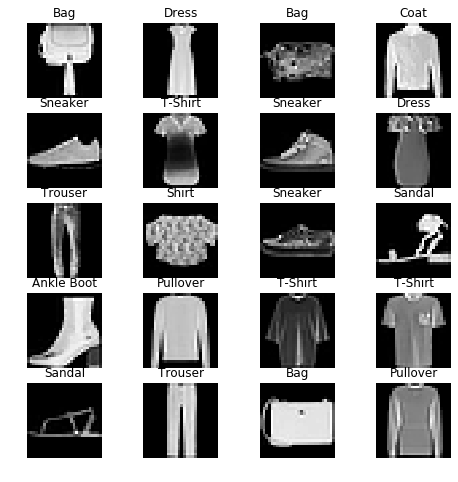

In [15]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [16]:
len(train_dataset)

60000

In [17]:
image.shape

(1, 28, 28)

In [18]:
batch = next(iter(train_loader))

In [19]:
image, labels = batch

In [20]:
image.shape
# 100 because we consider the batch size of 100

torch.Size([100, 1, 28, 28])

#### 100 for the batch size and 1 for the color channel 

In [21]:
labels.shape

torch.Size([100])

### Model

#### Dummy Network

Keep in mind to always extend nn.Module

write the layers

and implement the forward method

In [22]:
class Network(nn.Module):
    def __init__(self):
        # initialization of the super class nn.Module
        # This transforms the simple Network to the pytorch Network
        super(Network,self).__init__()
        self.layer = None
        # We implemented the 2 conv layers 
        # output channels are the number of filters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        # # fully connected or Dense layers
        # Last 10 corresponds to the number of output classes
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
    # taking tensor t and transforming it with the layer 
    def forward(self,t):
        # Input Layer(1)
        t = t.float()
        
        # Hidden Layer Conv(2)
        t = self.conv1(t)
        # No weights are required in activation function so directly calling from the nn.functional
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        # Hidden Layer Conv(3)
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        # Hidden Linear layer (4)
        t = t.reshape(-1,12*4*4)
        # This 4*4 is because of the convolution opn
        t = self.fc1(t)
        t = F.relu(t)
        
        # Hidden Linear layer (5)
        t = self.fc2(t)
        t = F.relu(t)
        
        #last Layer (6)
        t = self.out(t)
        # We wont use the softmax function because we uses the same in the cross entropy loss
        
        return t

In [23]:
network = Network()
network

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [24]:
network.conv1

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))

In [25]:
network.conv1.weight

Parameter containing:
tensor([[[[-1.3796e-01, -1.8006e-01, -1.8686e-01, -1.4179e-01,  9.6995e-02],
          [-7.9915e-02, -1.5198e-01,  8.6221e-02, -7.3639e-02, -9.4219e-02],
          [-1.4410e-01,  9.3482e-02, -8.5001e-02, -3.8153e-02, -1.7174e-01],
          [ 1.0083e-01,  4.4130e-02,  1.3478e-01, -1.5318e-01, -1.8223e-01],
          [-1.1837e-01,  2.3117e-02,  3.5218e-02,  1.3352e-02, -6.8811e-02]]],


        [[[-6.2156e-02,  1.4382e-01, -1.6191e-01, -5.7729e-02, -1.3593e-01],
          [ 1.9161e-02, -4.3296e-02, -1.9017e-01,  6.4559e-02, -1.9102e-02],
          [-1.7765e-01, -3.6156e-02, -3.6287e-02,  1.3404e-01, -1.1342e-01],
          [-8.0287e-02, -1.6446e-01, -1.6674e-01, -1.4835e-01,  8.1619e-02],
          [ 3.7314e-03,  3.8151e-02,  1.8253e-01, -9.9858e-02,  1.6540e-02]]],


        [[[-1.9359e-01, -1.1361e-01, -1.1988e-01,  6.2560e-03, -1.1452e-01],
          [ 1.2154e-01, -5.7795e-02,  1.5437e-01, -1.4049e-02, -6.6171e-02],
          [ 1.6520e-01, -1.3209e-01, -1.3825e-

In [26]:
for name, param in network.named_parameters():
    print(name, '\t\t', param.shape)

conv1.weight 		 torch.Size([6, 1, 5, 5])
conv1.bias 		 torch.Size([6])
conv2.weight 		 torch.Size([12, 6, 5, 5])
conv2.bias 		 torch.Size([12])
fc1.weight 		 torch.Size([120, 192])
fc1.bias 		 torch.Size([120])
fc2.weight 		 torch.Size([60, 120])
fc2.bias 		 torch.Size([60])
out.weight 		 torch.Size([10, 60])
out.bias 		 torch.Size([10])


### Computation graph Feature

Before we being, we are going to turn off PyTorch’s gradient calculation feature. This will stop PyTorch from automatically building a computation graph as our tensor flows through the network.

The computation graph keeps track of the network's mapping by tracking each computation that happens. The graph is used during the training process to calculate the derivative (gradient) of the loss function with respect to the network’s weights.

Since we are not training the network yet, we aren’t planning on updating the weights, and so we don’t require gradient calculations. We will turn this back on when training begins.

This process of tracking calculations happens in real-time, as the calculations occur. Remember back at the beginning of the series, we said that PyTorch uses a dynamic computational graph. We'll now we're turning it off.

Turning it off isn’t strictly necessary but having the feature turned off does reduce memory consumption since the graph isn't stored in memory. This code will turn the feature off. 

In [27]:
torch.set_grad_enabled(False)

### Learning

In [28]:
netowrk = Network()

In [29]:
sample = next(iter(train_dataset))

In [30]:
image, label = sample

In [31]:
image.shape

(1, 28, 28)

In [32]:
### For prediction we first need to have an extra dimension for the batches

In [33]:
type(image)

numpy.ndarray

In [34]:
image = torch.Tensor(image)

In [35]:
image.shape

torch.Size([1, 28, 28])

In [36]:
image.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [37]:
pred = network(image.unsqueeze(0))

In [38]:
pred

tensor([[-3.6866,  0.4029,  4.3619,  2.1831,  1.6256, -5.0579,  1.1495,  3.1567,  2.5245, -1.4848]])

In [39]:
pred.softmax(dim=1)

tensor([[1.8805e-04, 1.1228e-02, 5.8842e-01, 6.6593e-02, 3.8136e-02, 4.7719e-05, 2.3689e-02, 1.7631e-01, 9.3693e-02,
         1.7002e-03]])

In [40]:
batch =  next(iter(train_loader))

In [41]:
type(batch)

list

In [42]:
images, labels = batch

In [43]:
images.shape

torch.Size([100, 1, 28, 28])

In [44]:
images = images.float()


###  I have made deliberately network to float so that all params can be in float type and passing the float arguement as well viz., images

In [45]:
network = Network()
network = network.float()

In [46]:
pred = network(images)

In [47]:
pred = pred.softmax(dim=1)
pred.argmax(dim=1)

tensor([9, 0, 9, 9, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 0,
        0, 3, 9, 0, 9, 0, 9, 9, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 9, 0, 9, 0, 0, 0, 9, 0, 9, 0, 0, 9, 0,
        0, 0, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0, 9, 0, 9, 8, 0, 9, 9, 9, 0, 9])

In [48]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [49]:
labels

tensor([5, 9, 3, 5, 6, 0, 4, 6, 3, 1, 5, 0, 8, 7, 5, 9, 5, 6, 8, 3, 2, 5, 6, 3, 9, 8, 1, 8, 8, 9, 9, 4, 1, 1, 2, 3, 6,
        1, 1, 2, 3, 0, 8, 6, 2, 3, 6, 1, 0, 7, 8, 2, 9, 1, 5, 8, 2, 0, 8, 7, 4, 2, 9, 3, 1, 3, 0, 8, 7, 0, 8, 9, 3, 6,
        6, 1, 3, 4, 3, 8, 7, 7, 5, 7, 4, 6, 7, 6, 5, 5, 5, 8, 2, 1, 5, 8, 4, 8, 7, 6])

In [50]:
get_num_correct(pred,labels)

5

### Setting the pytorch's dynamic computational graph feature on

In [51]:
torch.set_grad_enabled(True)

### Calculating the Loss

In [52]:
preds = network(images)

In [53]:
loss = F.cross_entropy(preds,labels)
loss.item()

3.1903717517852783

### Calculating the grad

In [55]:
print(network.conv1.weight.grad)

None


In [56]:
loss.backward() # way of calculating the gradients

In [57]:
print(network.conv1.weight.grad.shape)

torch.Size([6, 1, 5, 5])


### Updating weights

In [59]:
optimizer = optim.Adam(network.parameters(), lr = learning_rate)

In [60]:
loss.item()

3.1903717517852783

In [61]:
get_num_correct(preds,labels)

5

In [62]:
optimizer.step() # updating the weights

In [63]:
preds = network(images)
loss = F.cross_entropy(preds,labels)
loss.item()

2.411308765411377

In [64]:
get_num_correct(preds,labels)

22

### Final Looping 

In [65]:
for epoch in range(10):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad() # We need to tell pytorch to zero the grads before calculating the new one
                              # otherwise it will start accumulating the gradients
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 48433 loss: 321.209530800581
epoch 1 total_correct: 51866 loss: 223.6103792488575
epoch 2 total_correct: 52738 loss: 199.67316679656506
epoch 3 total_correct: 53202 loss: 184.39726588129997
epoch 4 total_correct: 53582 loss: 174.00107617676258
epoch 5 total_correct: 53861 loss: 165.11224222183228
epoch 6 total_correct: 54232 loss: 156.34554932266474
epoch 7 total_correct: 54347 loss: 150.6634815260768
epoch 8 total_correct: 54439 loss: 147.55517929047346
epoch 9 total_correct: 54785 loss: 140.91444393992424


In [67]:
total_correct/len(train_dataset) # Accuracy

0.9130833333333334